In [1]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# label adapter

In [2]:
#model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
#save_predictions(model, test_ds)

## create our datasets

In [3]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        #albu.GaussNoise(p=0.2),
        #albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        #albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(128, 128)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None, training=True):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    if training == True:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][200::]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][200::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:200]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][:200]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    sample = self.augmentation(image=image, mask=mask)
    image, mask = sample['image'], sample['mask']

    image = torch.tensor(image)

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).float()

    return (image.permute(2,0,1).float(), one_hot_Y.permute(2,0,1).float())


train_x_path = "/home/nathan/Documents/final_project/datasets/label_adapter/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/label_adapter/masks"

val_x_path = train_x_path
val_y_path = train_y_path

train_ds2 = MyDataSet(train_x_path, train_y_path, None, augmentation=get_training_augmentation())
val_ds2 = MyDataSet(val_x_path, val_y_path, None, augmentation=get_validation_augmentation())


### Data Loader

In [4]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader2 = DataLoader(train_ds2, batch_size=24, shuffle=True, num_workers=7)
valid_loader2 = DataLoader(val_ds2, batch_size=24, shuffle=False, num_workers=7)
print(len(train_loader2))

75


2023-02-17 05:59:22.090583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 05:59:22.415418: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-17 05:59:23.716380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/miniconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/
2023-02-17 05:59:23.716527: W tensorflow/stream_executor

torch.Size([3, 128, 128])
torch.Size([11, 128, 128])


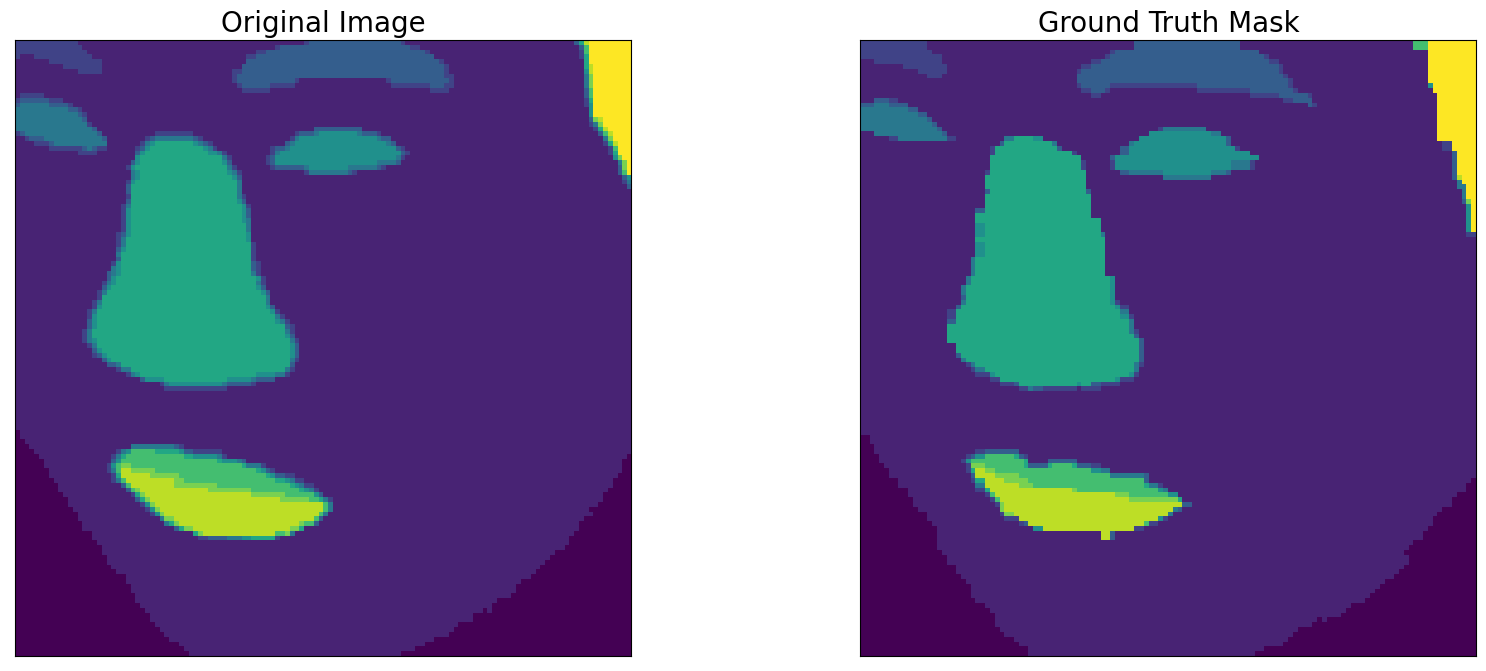

torch.Size([3, 128, 128])
torch.Size([11, 128, 128])


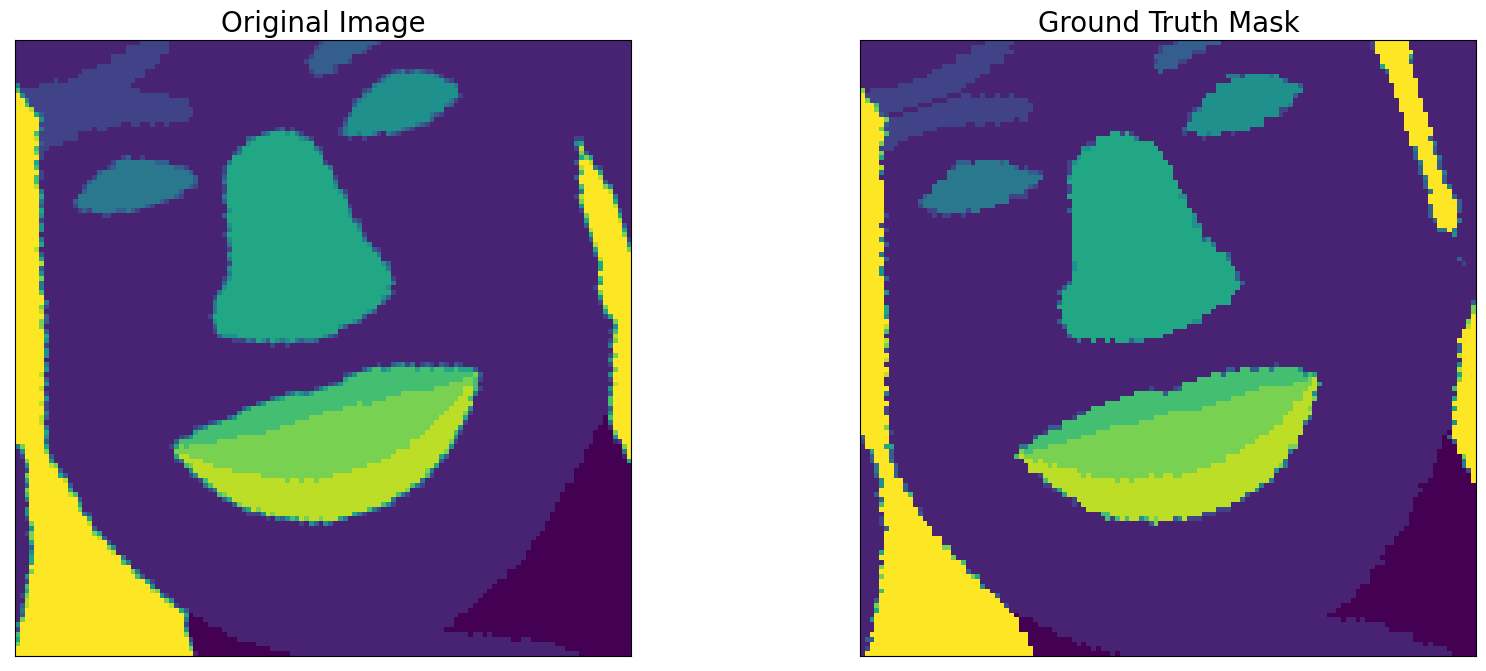

In [5]:
from PIL import ImageFilter
from scipy import ndimage
from collections import Counter
import label_test_script


for x in range(2):

    image_vis, gt_mask = train_ds2[x]
    print(image_vis.shape)
    print(gt_mask.shape)

    reverse = label_test_script.reverse_one_hot(gt_mask)

    skin_kernel = np.ones((4,4))

    tmp = scipy.ndimage.convolve(np.array(reverse), skin_kernel, mode='constant')
    filter = np.array(np.logical_and(np.array(tmp) >= 1, reverse)).astype(np.float32)

    label_test_script.visualize(
        original_image = image_vis[0,::],
        ground_truth_mask = reverse,
        #skin_kernel  = (filter),
    )

# custom FCN label adapter train

In [6]:
import torch.nn as nn
from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG

class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [7]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [9]:
from torch import optim
from torch.optim import ExponentialLR

num_classes = 11

fcn = FCN8s(VGG16(cfg,ranges), num_classes)
fcn.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.9035, 0.3277, 0.9819, 0.9839, 0.9888, 0.9888, 0.9209, 0.9869, 0.9863,
        0.9789, 0.9524]).to("cuda"))
optimizer = torch.optim.Adam([dict(params=fcn.parameters(), lr=0.001)])
scheduler = ExponentialLR(optimizer, gamma=0.9)

low_loss = 1
for epoch in range(100):
  for i, batch in enumerate(train_loader2):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    #print(output.shape, labels.shape)
    output = fcn(inputs)
    output = torch.sigmoid(output)
    loss = criterion(output.to(device), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    fcn.eval()
    if loss.item() < low_loss:
      low_loss = loss.item()
      torch.save(fcn.state_dict(), "/home/nathan/Documents/final_project/saved_models/label_adapted.pth")
    print("epoch: {}, i: {}, loss: {:.5f}".format(epoch, i, loss.item()),  end="\r")
    fcn.train()


/home/nathan/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_14855/738637007.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, requires_grad=False)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image

def average(lst):
    return sum(lst) / len(lst)

def view_label_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image.cpu()
        image_vis = image.cpu()
        image_vis = np.transpose(image_vis,(1,2,0))
        #print("vis:",image_vis.shape)
        #print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        #print("predraw", pred_mask.shape)
        #print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        #m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        #m.update_state(gt_mask, pred_mask)
        #iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        #ious.append(iou)

        #gt_mask = scipy.signal.medfilt(gt_mask, 9)

        #Get f1
        #m = MultiLabelBinarizer().fit(gt_mask)
        #f1 = f1_score(m.transform(gt_mask), m.transform(pred_mask), average=None)
        #if len(f1) == num_classes:
        #  f1s.append(f1)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          #print(f1)
          f1s.append(np.array(f1))

        try:
          if idx < 10:
            visualize(
                original_image = image[0,::],
                ground_truth_mask = gt_mask,
                predicted_mask = pred_mask,
            )
        except:
          if idx < 10:
            visualize(
                original_image = image.cuda()[0,::],
                ground_truth_mask = gt_mask.cuda(),
                predicted_mask = pred_mask.cuda(),
            )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    #print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

2023-02-17 01:56:49.455990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 01:56:49.863702: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-17 01:56:51.274813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/miniconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/:/home/nathan/miniconda3/lib/
2023-02-17 01:56:51.275156: W tensorflow/stream_executor

/tmp/ipykernel_19707/2303181985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
/tmp/ipykernel_19707/2303181985.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


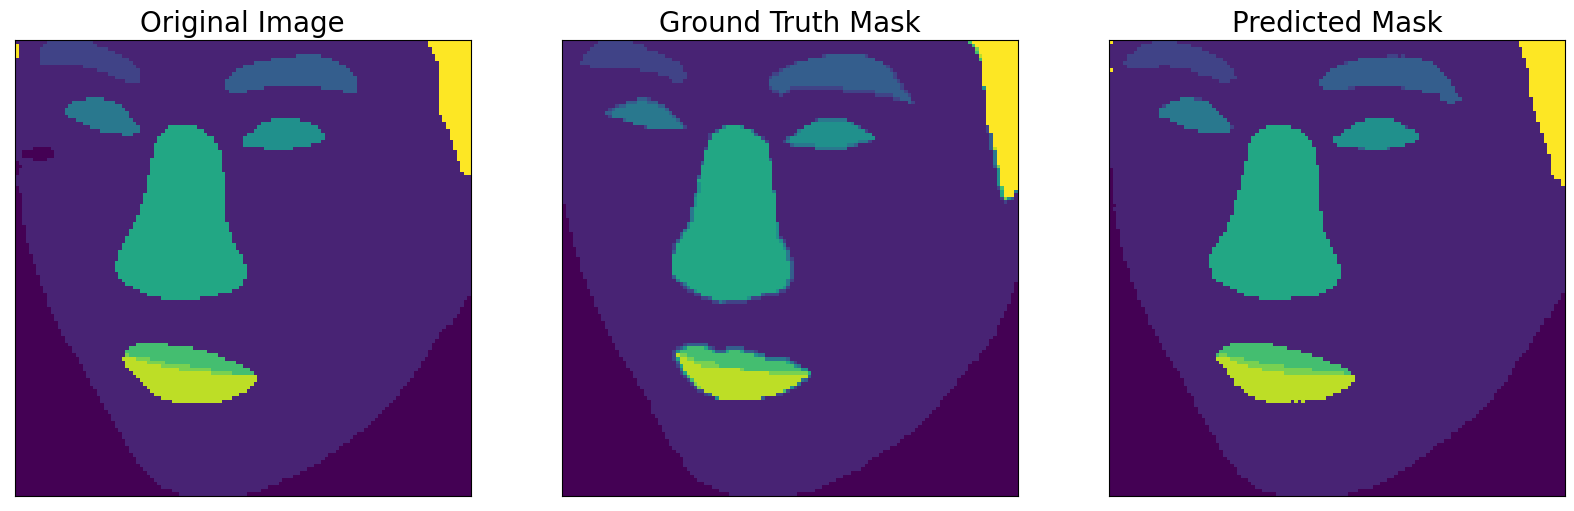

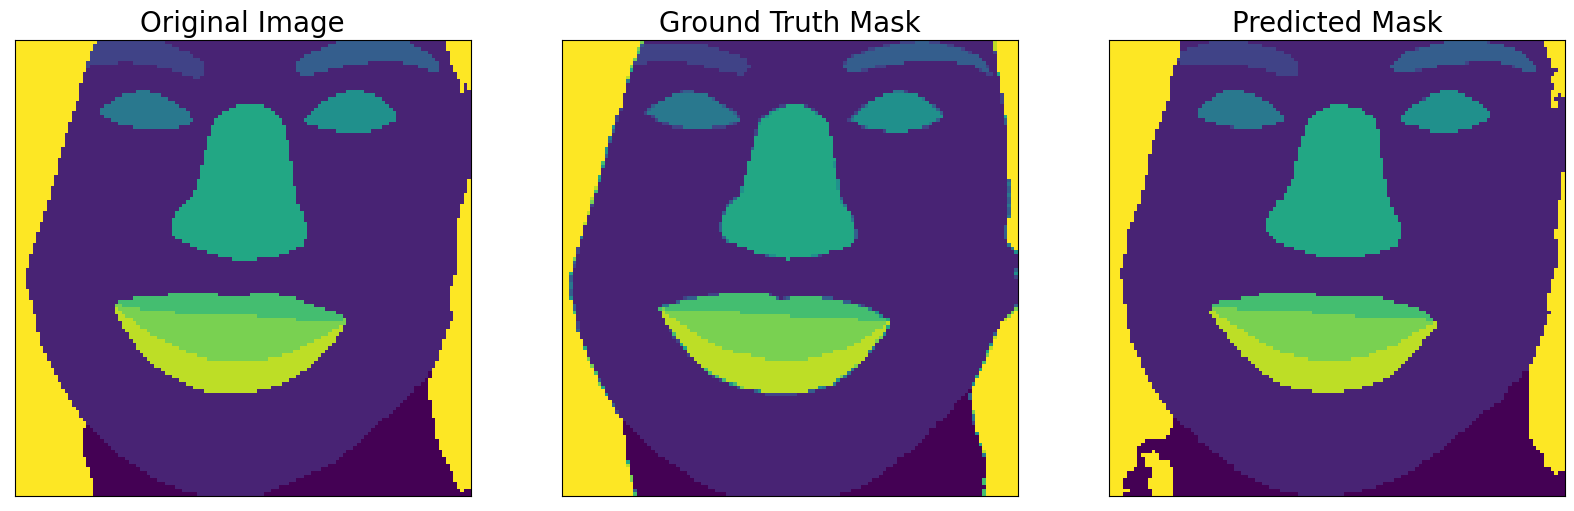

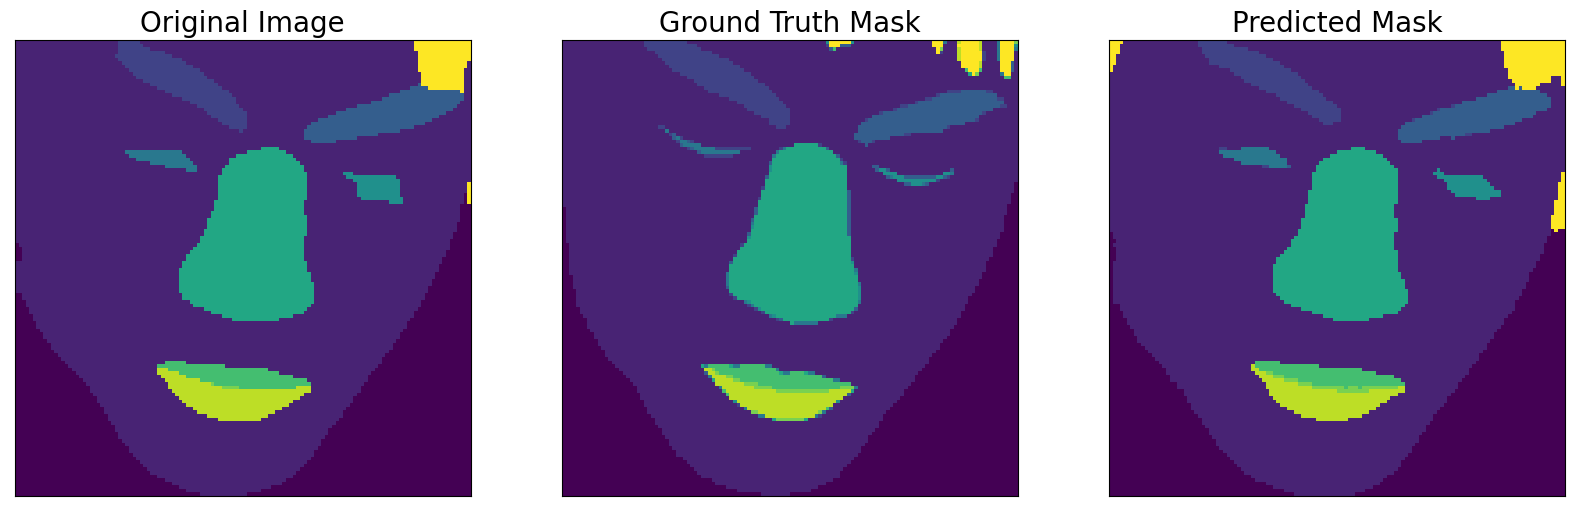

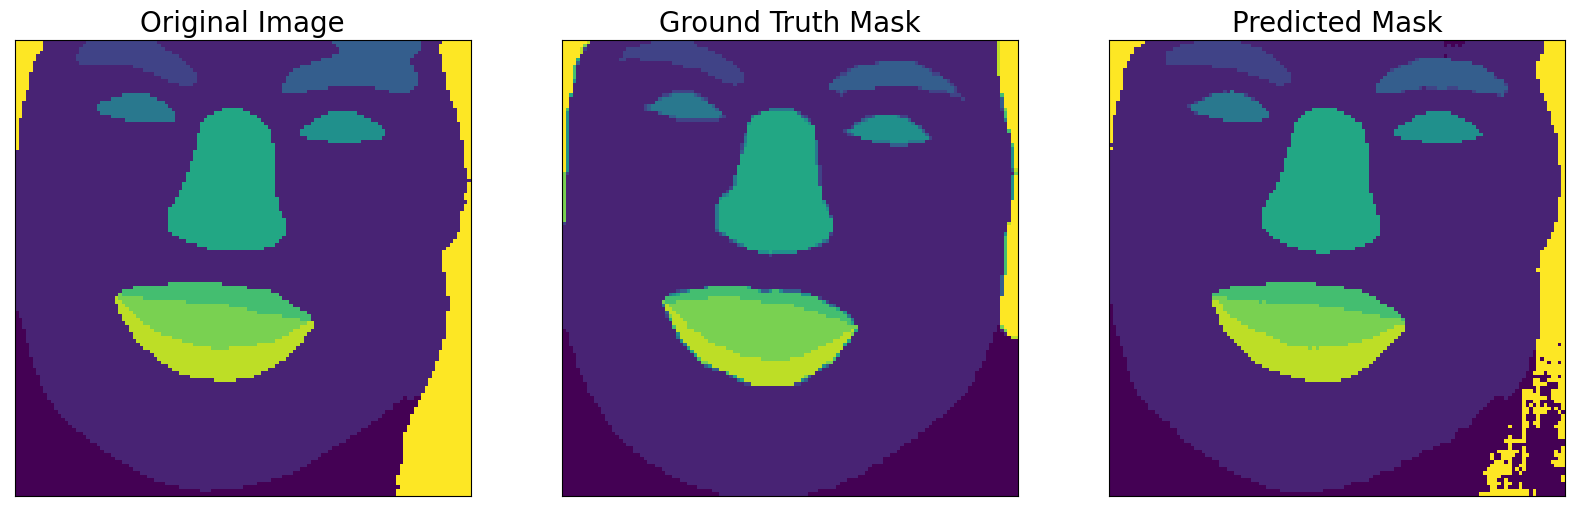

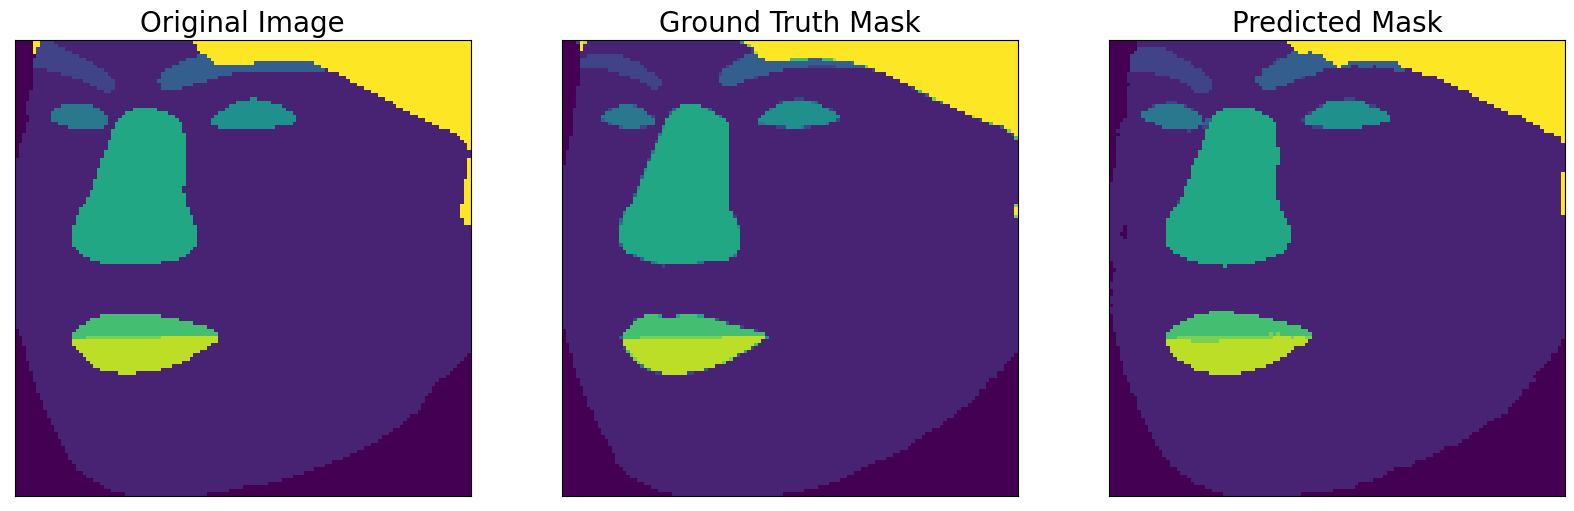

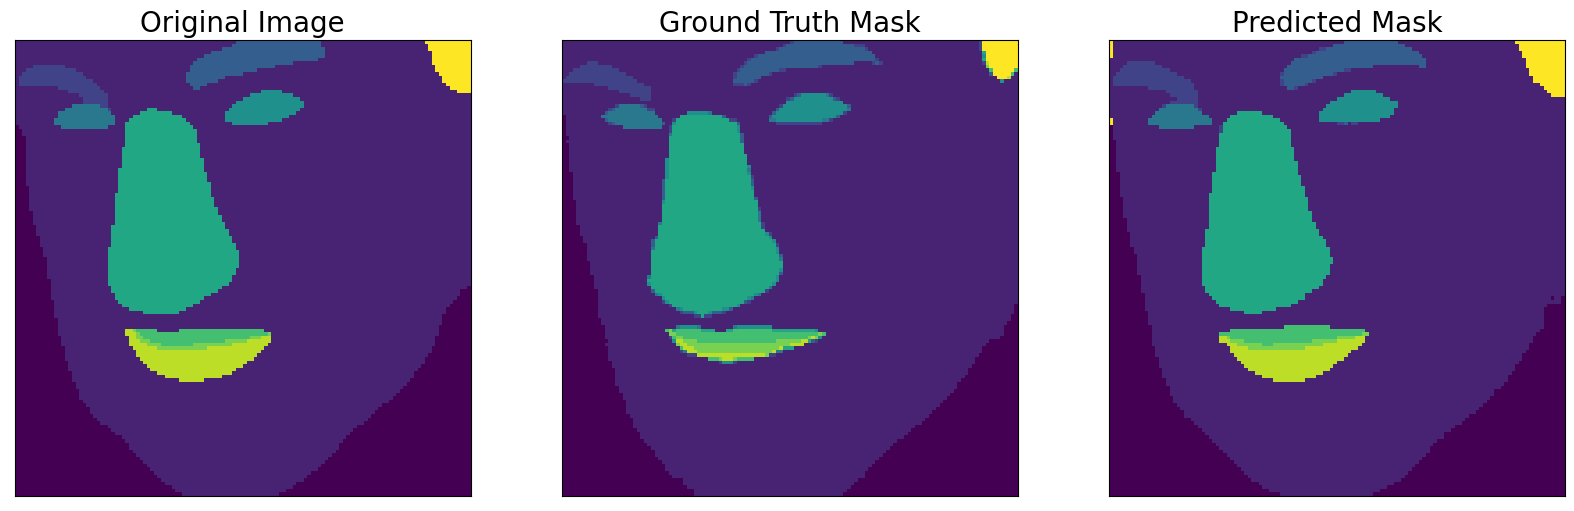

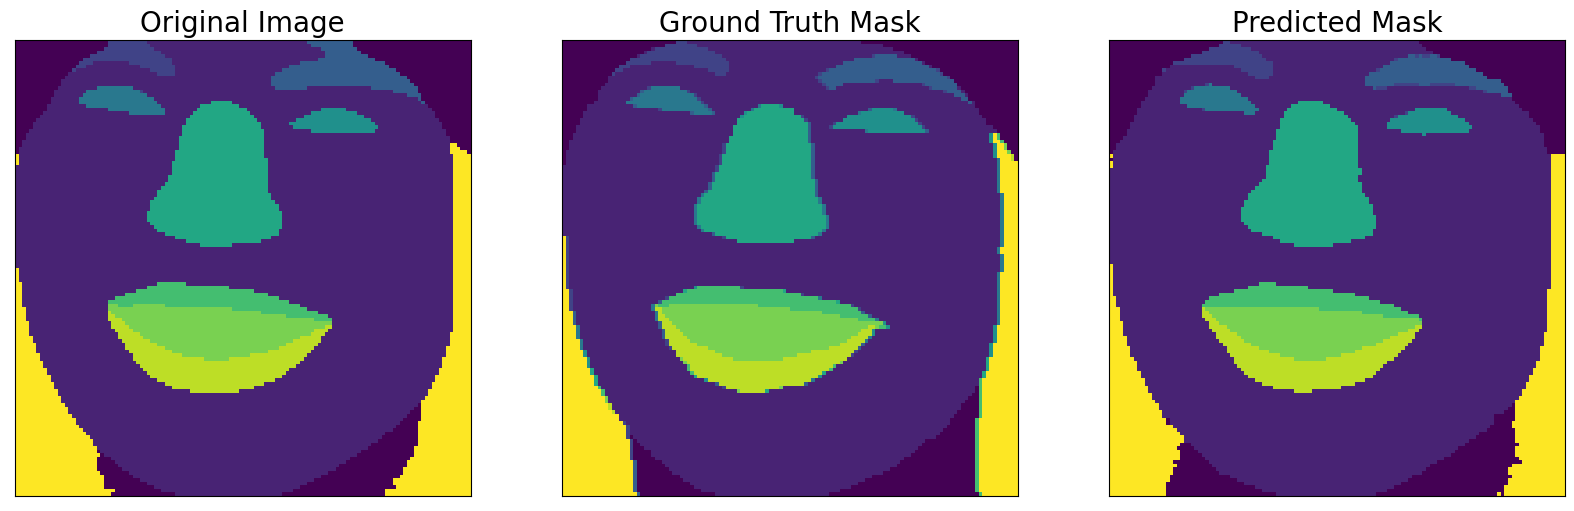

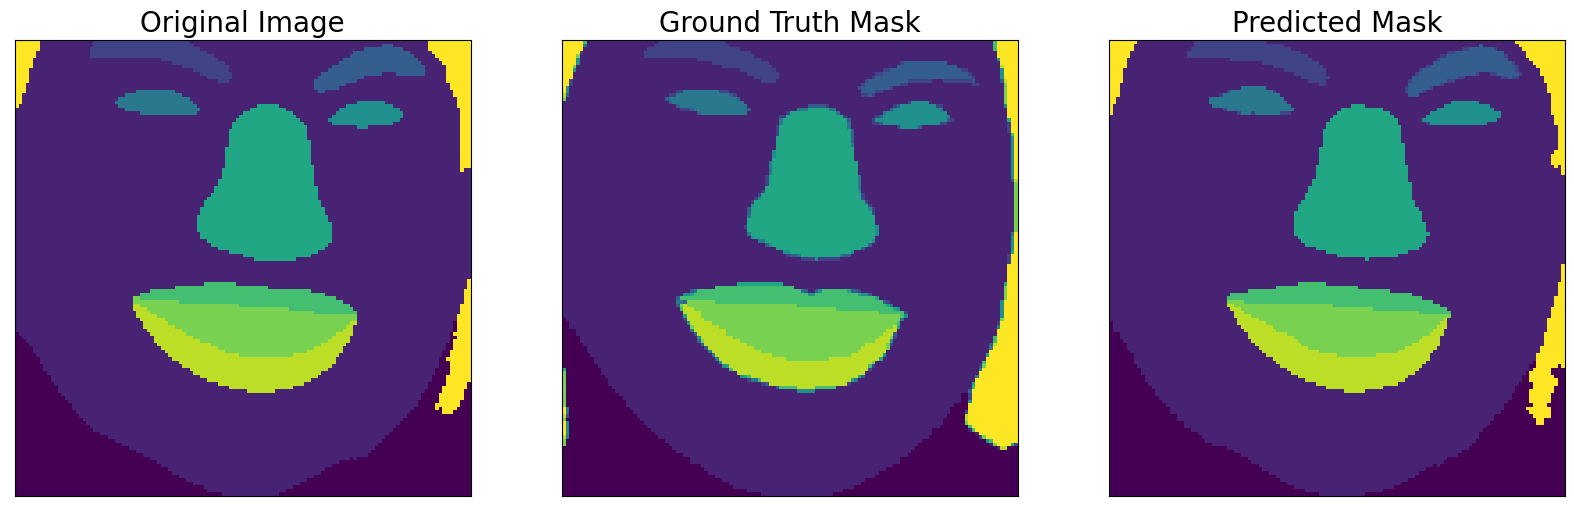

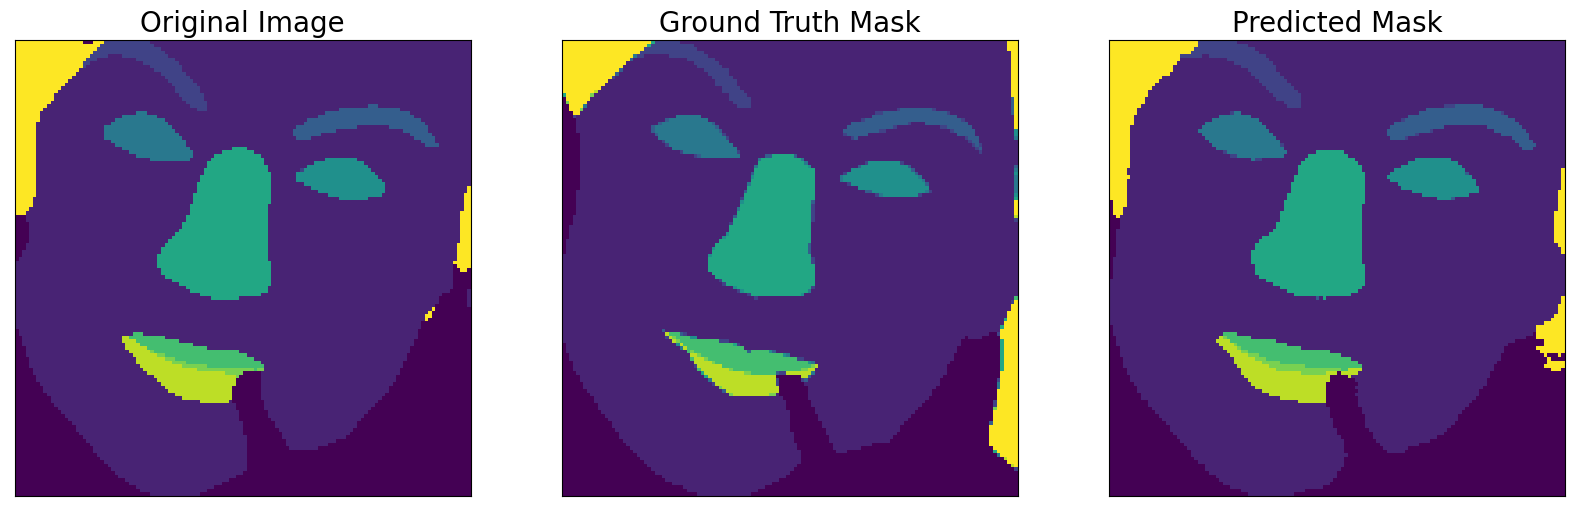

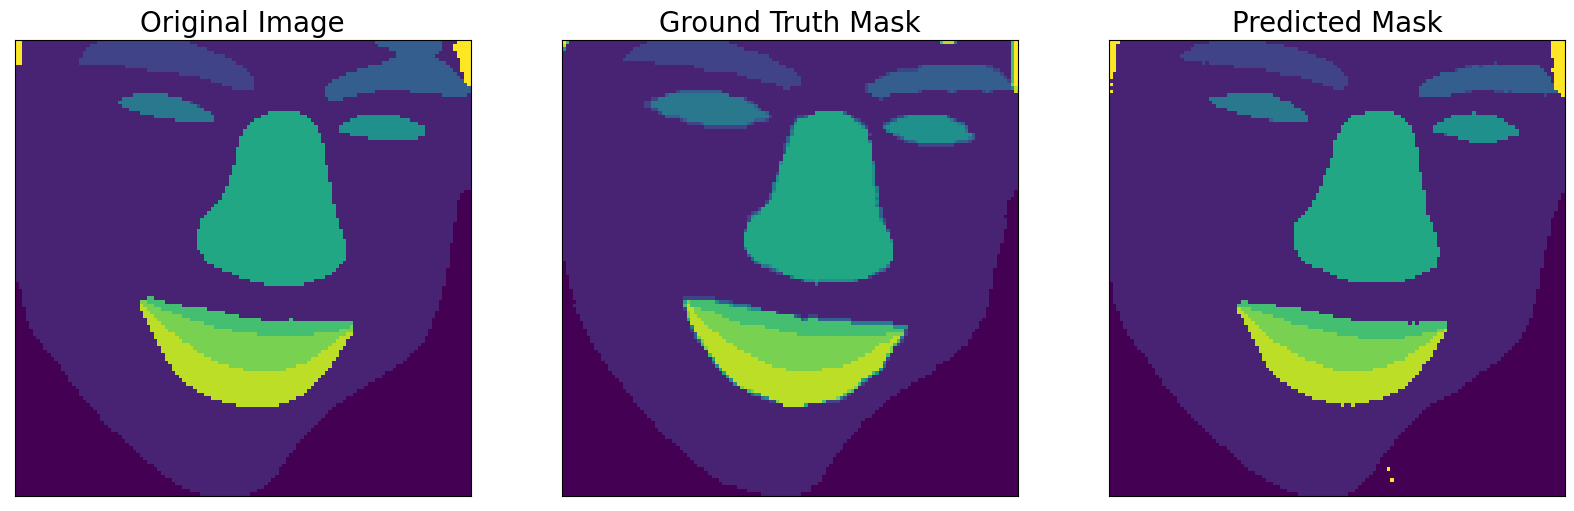

Dataset F1 =  [0.8683056  0.9672985  0.70372564 0.75466895 0.7226074  0.7241556
 0.94528294 0.79603964 0.69647086 0.8462012  0.7448921 ]
Dataset F1 av =  0.7972408


In [ ]:
DEVICE="cuda:0"
rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]

model = fcn
model.load_state_dict(torch.load('/home/nathan/Documents/final_project/saved_models/label_adapted.pth'))

view_label_predictions(model,val_ds2, num_classes)